# Convolutional Neural Networks using Tensorflow and Keras

We will work through creating a convolutional neural network from scratch.

## Step 1 - Import the data

We will use `image_dataset_from_directory` to build our training and validation sets. This function expects our images to be in folders separated by class, and the classifcation values are inferred from the folder names.

In [40]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# You can mess with batch size
BATCH_SIZE = 16
IMAGE_SIZE = (224,224)
SEED = 1

# This sets up a training and validation set from our ../data/ directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '../data/',
    class_names = ['not_niblet','niblet'],
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=SEED)

# This is the validation set. Notice `shuffle = FALSE` and `subset = validation`
val_dataset = tf.keras.utils.image_dataset_from_directory(
    '../data/',
    class_names = ['not_niblet','niblet'],
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=SEED)

Found 1729 files belonging to 2 classes.
Using 1384 files for training.
Found 1729 files belonging to 2 classes.
Using 345 files for validation.


## Step 2 - Set up the image augmentation and preprocessing

This [tutorial](https://www.tensorflow.org/guide/keras/preprocessing_layers) provides some of the preprocessing and image augmentation option using Keras layers. We will be integrating the preprocessing and augmentation into our model, which streamlines the process and makes the model more portable. But the tutorial also presents an alternate way that may be more efficient if you are training using your CPU (which we are unless you do some extra setup to utilize a GPU).

You can experiment with some of the other image augmentation layers such as:
* tf.keras.layers.RandomCrop
* tf.keras.layers.RandomFlip
* tf.keras.layers.RandomTranslation
* tf.keras.layers.RandomRotation
* tf.keras.layers.RandomZoom
* tf.keras.layers.RandomContrast

We will also be applying some preprocessing to rescale the images to have color values in [0,1] instead of [0,255] and to crop/resize the images down to (224,224). We don't need the cropping for the images that we processed last class period, but this will allow us to use our model on any size image without worrying about processing it first.

In [41]:
from tensorflow.keras import layers

image_preprocess = tf.keras.Sequential([
    tf.keras.Input((None,None,3)),
    layers.Resizing(224,224, crop_to_aspect_ratio = True),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(.5,.2) #added RandomZoom, idk if this will really do anything
])

image_preprocess.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Test out our image augmentation:

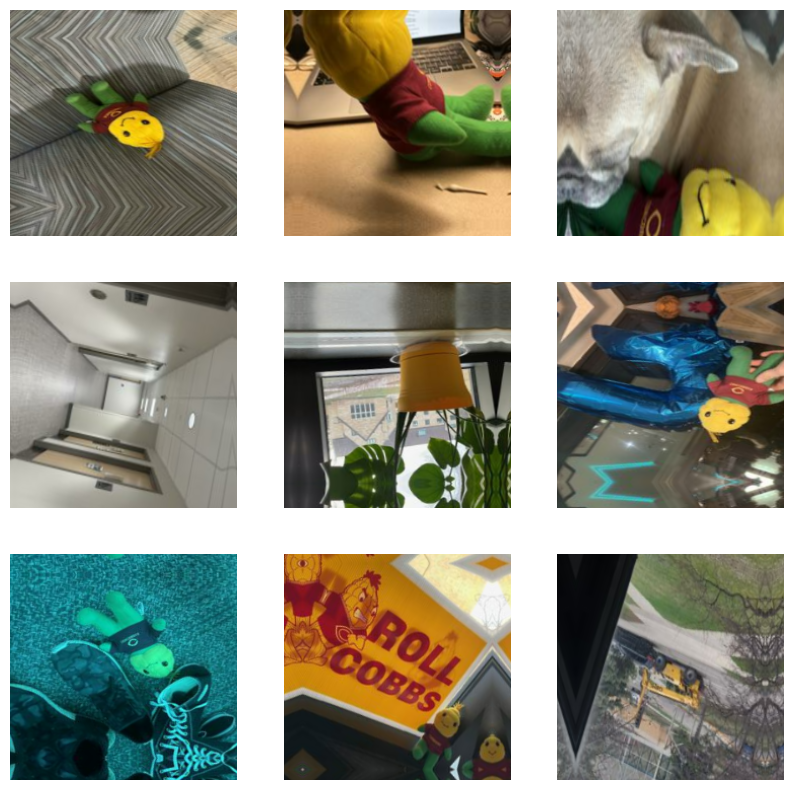

In [42]:
iterator = iter(train_dataset)

plt.figure(figsize=(10, 10))
for i in range(9):
  image = tf.cast(tf.expand_dims(next(iterator)[0][0], 0), tf.float32)
  augmented_image = image_preprocess(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

## Step 3 - Sequential Layers

The main layers we will use are:
* [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) - Convolutional layer
* [AveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D) or [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) - Pooling layers
* [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) - After all the convolutions are done, this flattens the 2D image to a vector.
* [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) - Fully connected layer
* [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) - Randomly masks a portion of the previous layer during training.

You can experiment with the parameters in these layers.

In [55]:
# Dr. Tanner's Models

nnet_layers = tf.keras.Sequential([
    tf.keras.Input((224,224,3)),
    layers.Conv2D(filters = 4, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Flatten(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'sigmoid')
])

nnet_layers.summary()

# My Models

# Model 2: AveragePooling2D instead of MaxPooling2D
nnet_layers2 = tf.keras.Sequential([
    tf.keras.Input((224,224,3)),
    layers.Conv2D(filters = 4, kernel_size = (3,3), activation = 'relu'),
    layers.AveragePooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu'),
    layers.AveragePooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu'),
    layers.AveragePooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    layers.AveragePooling2D(pool_size = (2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    layers.AveragePooling2D(pool_size = (2,2)),
    layers.Flatten(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'sigmoid')
])

nnet_layers2.summary()

from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D

# Model 3: adding normalization

nnet_layers3 = tf.keras.Sequential([
    tf.keras.Input((224,224,3)),
    layers.Conv2D(filters = 4, kernel_size = (3,3), activation = 'relu'),
    BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 8, kernel_size = (3,3), activation = 'relu'),
    BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu'),
    BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
    BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = "sigmoid")
])

nnet_layers3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 222, 222, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 109, 109, 8)    │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 52, 52, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     1,639,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729,801 (6.60 MB)

 Trainable params: 1,729,801 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 222, 222, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_10            │ (None, 111, 111, 4)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 109, 109, 8)    │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_11            │ (None, 54, 54, 8)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 52, 52, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 26, 26, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_13            │ (None, 12, 12, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_14            │ (None, 5, 5, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     1,639,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729,801 (6.60 MB)

 Trainable params: 1,729,801 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 222, 222, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 4)    │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 111, 111, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 109, 109, 8)    │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 54, 54, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 52, 52, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,433 (614.97 KB)

 Trainable params: 157,185 (614.00 KB)

 Non-trainable params: 248 (992.00 B)

Put the model together:

In [57]:
# Dr. Tanner's 

inputs = tf.keras.Input(shape=(224,224, 3))
x = image_preprocess(inputs)
outputs = nnet_layers(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

# Mine

outputs2 = nnet_layers2(x)
model2 = tf.keras.Model(inputs, outputs2)
model2.summary()

outputs3 = nnet_layers3(x)
model3 = tf.keras.Model(inputs, outputs3)
model3.summary()

Model: "functional_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 1)              │     1,729,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729,801 (6.60 MB)

 Trainable params: 1,729,801 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 1)              │     1,729,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,729,801 (6.60 MB)

 Trainable params: 1,729,801 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 1)              │       157,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,433 (614.97 KB)

 Trainable params: 157,185 (614.00 KB)

 Non-trainable params: 248 (992.00 B)

Compile the model:

In [69]:
metrics = [tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy'),
           tf.keras.metrics.AUC(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.FalseNegatives()
          ]

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=metrics)

# Mine

model2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=metrics)

model3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=metrics)

## Step 4 - Train the Model

Time for some popcorn

In [70]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=15, monitor='val_loss')

#model.fit(train_dataset, epochs=100,
#         validation_data=val_dataset,
#          callbacks=[es])

#model2.fit(train_dataset, epochs=100,
#         validation_data=val_dataset,
#          callbacks=[es])

model3.fit(train_dataset, epochs=100,
         validation_data=val_dataset,
          callbacks=[es])

Epoch 1/100


87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.9162 - auc: 0.9780 - false_negatives: 35.9545 - false_positives: 21.9432 - loss: 0.1848 - true_negatives: 294.4546 - true_positives: 359.2841 - val_accuracy: 0.8986 - val_auc: 0.9559 - val_false_negatives: 21.0000 - val_false_positives: 14.0000 - val_loss: 0.2953 - val_true_negatives: 134.0000 - val_true_positives: 176.0000
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.9210 - auc: 0.9694 - false_negatives: 29.7955 - false_positives: 26.1591 - loss: 0.2196 - true_negatives: 286.0796 - true_positives: 369.6023 - val_accuracy: 0.8986 - val_auc: 0.9587 - val_false_negatives: 25.0000 - val_false_positives: 10.0000 - val_loss: 0.2990 - val_true_negatives: 138.0000 - val_true_positives: 172.0000
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.9332 - auc: 0.9776 - false_negatives: 33.0000 - false_positives: 16.5795 - loss: 0.1881 - true_negatives: 298.2273 - true_positives: 363.8296 - val_accuracy

## Step 5 - Save the model

If you like your model, then save your model.

In [71]:
model3.save('../models/cnn_model_rdf_2024_04_29_model3.keras')

## Step 6 - Load the model (if necessary)

If you already saved a model, you can load it again.

In [72]:
model_to_test = tf.keras.models.load_model('../models/cnn_model_rdf_2024_04_29_model3.keras')

## Step 7 - Test the Model

In [73]:
# This is the validation set. Notice `shuffle = FALSE` and `subset = validation`
test_set = tf.keras.utils.image_dataset_from_directory(
    '../test/all/',
    class_names = ['not_niblet','niblet'],
    color_mode='rgb',
    batch_size=200,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED)

test_iterator = iter(test_set)
test_batch, _ = next(test_iterator)

# Test Shapes

#model_to_test.summary()

#print(test_batch[0].shape)

Found 192 files belonging to 2 classes.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


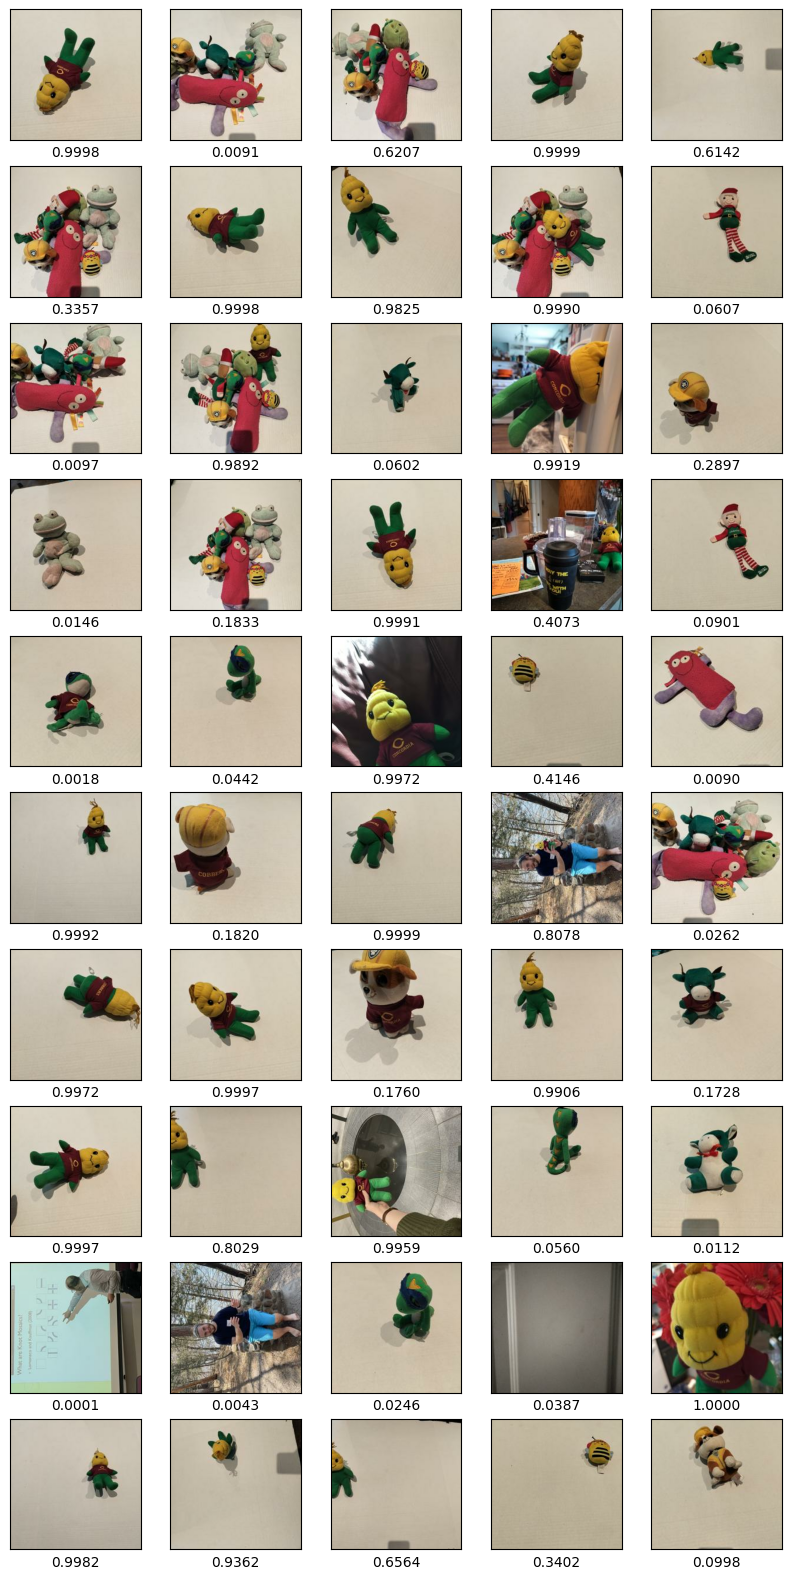

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step - accuracy: 0.8854 - auc: 0.9528 - false_negatives: 9.0000 - false_positives: 13.0000 - loss: 0.3129 - true_negatives: 89.0000 - true_positives: 81.0000


{'accuracy': 0.8854166865348816,
 'auc': 0.9528322219848633,
 'false_negatives': 9.0,
 'false_positives': 13.0,
 'loss': 0.3128760755062103,
 'true_negatives': 89.0,
 'true_positives': 81.0}

In [74]:
import matplotlib.pyplot as plt

predictions = model_to_test.predict(test_batch)

plt.figure(figsize=(10,20))
for i in range(50):
    plt.subplot(10,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_batch[i]/255)
    plt.xlabel("{pred:.4f}".format(pred = predictions[i][0]))
plt.show()

model_to_test.evaluate(test_set, return_dict = True)